# Способы непрерывного мониторинга АБ-тестов

*Подготовил Ян Пиле*

Из каждого утюга мы слышим про "принятие решений на основе данных" и A/B-тестирование уже стало неотъемлемым инструментом для бизнеса, маркетинга и разработки продуктов, поскольку оно позволяет принимать решения, опираясь на статистически обоснованные выводы. Практически везде используются тесты с заранее определенным размером выборки или, что называется, fixed-horizon тесты. Думаю, что ваша команда не исключение и у вас в руках та или иная модификация бутстрепа, t-теста или Манна-Уитни, если это не так и ваш способ к этим методам не сводится (если это не Causal Inference), пожалуйста напишите мне, я буду очень рад узнать что-то новое (**tg: @ianpile**). Этот способ себя зарекомендовал достаточно хорошо, поскольку при корректно построенном тесте напрямую контролируется уровень ошибки первого рода (ложные срабатывания) на уровне $FPR \le  \alpha$

Тем не менее, вам наверное знакомо жгучее желание поглядеть "что там с тестом происходит и как там метрики", однако почему-то у многих это действие вызывает почти хтонический ужас с криками "ну, так же нельзя - подглядывать за тестами! это не по правилам!", как будто в процессе наблюдения произойдет чуть ли не редукция кота Шрёдингера и вы напрямую этим наблюдением измените результат теста. 

<img src = "https://github.com/pileyan/pictures/blob/master/t-test%20cat.jpg?raw=true" width=550>

Я хотел бы рассказать, что нужно сделать , чтобы от этого страха избавиться и как можно действительно "мониторить" тесты. 

## Короткий план

1. Почему "за тестами нельзя подглядывать" и почему за тестами нельзя подглядывать на самом деле.
2. Задача о разорении игрока и тесты конверсии.
3. SPRT или t-тест Хайнала.
4. GST – буквально ОЧЕНЬ похож на задачу о разорении игрока :).
5. CUSUM как продолжение SPRT / альтернативный взгляд на происходящее).

# Почему "за тестами нельзя подглядывать"

Обычные корректно специфицированные тесты должны вам ГАРАНТИРОВАТЬ, что доля ложных срабатываний ограничена (ну или хоть +- ограничена) вашим уровнем доверия $\alpha$. Непрерывное заглядывание в тест **при условии, что вы будете принимать решение о значимом результате теста, основываясь на неполной статистике** эту гарантию нарушает.

Начнем с простого:

In [1]:
import numpy as np
from tqdm import tqdm
from scipy.stats import ttest_ind

num_simulations = 1000  # Кол-во прогонов
n_start = 50  # Исходное кол-во данных 
n_end = 1000  # Размер выборки, "который должен быть"
alpha = 0.05  # Уровень доверия

type1_errors_continuous = 0  
type1_errors = 0

# Run simulations
for _ in tqdm(range(num_simulations)):
    # Данные из одного и того же распределения
    group1 = np.random.normal(loc=0, scale=1, size=n_end)
    group2 = np.random.normal(loc=0, scale=1, size=n_end)
    
    rejected = False
    # Прогоняем t-тест последовательно и проверяем наличие отличий
    for k in range(n_start, n_end + 1, 50):
        sample1 = group1[:k]
        sample2 = group2[:k]
        _, p_value = ttest_ind(sample1, sample2)
        
        if p_value < alpha:
            rejected = True
            break  # Останавливаемся, если нулевая гипотеза отвергается
    
    if rejected:
        type1_errors_continuous += 1
    _, p_value = ttest_ind(group1, group2)
    if p_value < alpha:
        type1_errors+=1

# Доля ошибок
error_rate_continuous = type1_errors_continuous / num_simulations
error_rate = type1_errors / num_simulations
print(f"Фактическая доля ложных срабатываний за {num_simulations} симуляций у непрерывного мониторинга: {error_rate_continuous:.3f}")
print(f"Фактическая доля ложных срабатываний за {num_simulations} симуляций у обычного t-теста: {error_rate:.3f}")

100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 129.10it/s]

Фактическая доля ложных срабатываний за 1000 симуляций у непрерывного мониторинга: 0.257
Фактическая доля ложных срабатываний за 1000 симуляций у обычного t-теста: 0.041


Разница в 5 раз) Думаю, вполне понятно, почему на такую штуку полагаться нельзя.

На мой взгляд, тем не менее, абсолютно не вредно пересчитывать результаты тестов периодически, чтобы смотреть, в какую сторону движется результат. Более того - чаще всего (в моей личной практике) успешные тесты давали результат в течение некоторого срока и далее разницу можно было наблюдать на графиках основных метрик. Например я уверен, что есть существенная разница между ситуациями, когда ваша метрика в группе А была в течение всех дней теста выше чем метрика в группе Б и прокрасилась, и когда метрики болтало туда-сюда друг относительно друга, но в итоге метрика все же прокрасилась (мне лично кажется более убедительным вариант из пункта 1.

**Настоящая причина того, что "тесты мониторить нельзя" в том, что вы часто ЗАРАНЕЕ принимаете решение** и далее уже не очень готовы от него отказаться.


# Задача о разорении игрока

Этот материал – переведенный блок [отсюда](https://www.evanmiller.org/sequential-ab-testing.html), на авторство не претендую.

Одна из самых частых метрик, которые используются в АБ – различные виды конверсий (из просмотра в клик, из клика в заказ, из заказа в выкуп заказа и так далее). Чаще всего такая штука моделируется биномиальным распределением, а результат анализируется с помощью $z$-теста. 

Вообще говоря, если пользователи случайным образом распределены по двум группам теста, и две группы имеют одинаковую конверсию, то последовательность успехов из двух групп математически [эквивалентна серии случайных подбрасываний монеты](https://elem.com/~btilly/ab-testing-multiple-looks/part1-rigorous.html).

В любой момент времени мы можем построить переменную $d$, которая представляет собой количество «орлов» (то есть успехов от тестовой группы) минус количество «решек» (то есть успехов от контрольной группы). По мере накопления наблюдений случайная величина $d$ описывается простым одномерным случайным блужданием. Если тестовая группа имеет такую же конверсию, как и контроль, случайное блуждание будет симметричным; потому что следующий успех с такой же вероятностью будет получен от тестовой группы, как и от контроля, после каждого успеха $d$ с такой же вероятностью увеличится, как и уменьшится. Но если коэффициенты конверсии не равны, случайное блуждание будет иметь тенденцию смещаться в одну или другую сторону.

Случайные блуждания довольно хорошо изученная штука, спасибо [Ширяеву](https://ru.wikipedia.org/wiki/Ширяев,_Альберт_Николаевич), например. Так тесты для простых бинарных конверсий довольно хорошо известны, но есть интересная взаимосвязь этих тестов с так называемой **задачей о разорении игрока** как раз из области случайных процессов.

<img src = "https://github.com/pileyan/pictures/blob/master/gambler.jpg?raw=true" width=550>

Дальнейшие выкладки можно частично подсмотреть [тут](https://bitcoinwords.github.io/assets/papers/an-introduction-to-probability-theory-and-its-applications.pdf) в главе 14.

### **Задача о разорении игрока**  

Представьте игрока с **$d$** фишками, который подбрасывает монету против оппонента. Если игрок угадывает орла или решку, он получает фишку от оппонента; если ошибается — теряет фишку. Игра заканчивается, когда у игрока или оппонента не остаётся фишек (т.е. один из них «разорён»).

#### Математическая модель честной монетки
Если оппонент имеет бесконечное число фишек, вероятность того, что игрок с начальным капиталом **$d$** будет разорён ровно за **$n$** бросков, задаётся формулой:  

$$
r_{n,d} = \frac{d}{n} \cdot \binom{n}{\frac{n+d}{2}} \cdot 2^{-n}
$$

где $\binom{n}{\frac{n+d}{2}}$ — биномиальный коэффициент (определён только при чётности $n + d$.

Вероятность разорения в первые **$N$** бросков:  

$$
R_{N,d} = \sum_{n=1}^{N} r_{n,d} = \sum_{n=1}^{N} \frac{d}{n} \cdot \binom{n}{\frac{n+d}{2}} \cdot 2^{-n}
$$

---

### **Связь с A/B-тестированием**  
Рассмотрим разницу $T - C$ между успехами в группах $T$ (тест) и $C$ (контроль). Каждый успех в $T$ увеличивает $T - C$ на 1, а в $C$ — уменьшает на 1. Это аналогично игре с фишками, где $d = T - C$.  

Если начать с $d = 0$, вероятность «дрейфа» до $d^*$ равна вероятности разорения игрока с начальным капиталом $d^*$. Это позволяет использовать формулу $R_{N,d}$ для **последовательного одностороннего теста** значимости в A/B-тестах.  

Для заданных **$N$** и уровня значимости $\alpha$ находят минимальное $d^* > 0$, удовлетворяющее:  

$$
\sum_{n=1}^{N} \frac{d^*}{n} \cdot \binom{n}{\frac{n + d^*}{2}} \cdot 2^{-n} < \alpha
$$

Если $d$ достигает $d^*$ за **$N$** или меньше шагов, нулевая гипотеза $H_0$ (отсутствие эффекта) отклоняется.  

#### Приближение критического значения $d^*$ 
$$
d^* \approx z_{\alpha/2} \cdot \sqrt{N}
$$

где $z_{\alpha/2}$ — квантиль нормального распределения уровня $1 - \alpha/2$. Для $\alpha = 0.05$, $z_{\alpha/2} = 1.96$. Округляя до 2, получаем эмпирическое правило:  

$$
d^* \approx 2 \cdot \sqrt{N}
$$


In [389]:
### Проверка через симуляцию, что alpha выглядит нормально 

def simulate_gamblers_ruin(N=1000, alpha=0.05, num_simulations=10000):
    z_alpha = 1.96  # Для alpha=0.05
    critical_value = z_alpha * np.sqrt(N)
    stopped = 0  # Счётчик отклонений H0

    for _ in range(num_simulations):
        d = 0
        for _ in range(N):
            d += np.random.choice([-1, 1])  # "Успех" или "неудача"
            if d > critical_value:
                stopped += 1
                break

    type_i_error = stopped / num_simulations
    print(f"Ошибка I рода: {type_i_error:.4f}")

# Запуск симуляции
simulate_gamblers_ruin(N=1000, alpha=0.05)

Ошибка I рода: 0.0535


### **Уравнение мощности для определения размера выборки**  
Чтобы выбрать значение $N$, необходимое для достижения желаемой **статистической мощности**, рассмотрим следующий подход. Предположим, мы хотим обнаружить эффект величиной $\delta$. Например, увеличение конверсии на 10% соответствует $\delta = 0.10$.  

#### **Доли успехов в группах**  
При альтернативной гипотезе $H_a$: эффект существует:

- Доля успехов в контрольной группе $C$:  
$$
  p = \frac{p_c}{p_c + p_t} = \frac{1}{1 + \frac{p_t}{p_c}} = \frac{1}{1 + (1 + \delta)} = \frac{1}{2 + \delta}
$$ 
- Доля успехов в экспериментальной группе $T$:  
$$
  1 - p = 1 - \frac{1}{2 + \delta} = \frac{1 + \delta}{2 + \delta}
$$

### **Вероятность разорения с нечестной монетой**  
Если монета имеет смещение $p < \frac{1}{2}$, вероятность разорения игрока с начальным капиталом $d$ за $n$ бросков:  
$$
r_{n,d} = \frac{d}{n} \cdot \binom{n}{\frac{n+d}{2}} \cdot p^{\frac{n-d}{2}} \cdot (1-p)^{\frac{n+d}{2}}
$$ 
Вероятность разорения в первые $N$ бросков:  
$$
R_{N,d} = \sum_{n=1}^{N} r_{n,d} = \sum_{n=1}^{N} \frac{d}{n} \cdot \binom{n}{\frac{n+d}{2}} \cdot p^{\frac{n-d}{2}} \cdot (1-p)^{\frac{n+d}{2}}
$$



### **Оптимальный размер выборки**  
Для заданных уровня значимости $\alpha$ и мощности $1 - \beta$ находят минимальные $N$ и $d^*$, удовлетворяющие:  
1. **Контроль ошибки I рода** (при $\delta = 0$):  
   $$
   \sum_{n=1}^{N} \frac{d^*}{n} \cdot \binom{n}{\frac{n + d^*}{2}} \cdot 2^{-n} < \alpha
   $$
2. **Обеспечение мощности** (при $\delta > 0$):  
   $$
   \sum_{n=1}^{N} \frac{d^*}{n} \cdot \binom{n}{\frac{n + d^*}{2}} \cdot \left( \frac{1}{2+\delta} \right)^{\frac{n-d^*}{2}} \cdot \left( \frac{1+\delta}{2+\delta} \right)^{\frac{n+d^*}{2}} \geq 1 - \beta
   $$ 


---

У Эвана Миллера уже есть [калькулятор](https://www.evanmiller.org/ab-testing/sequential.html) для последовательного теста конверсии на основании "задачи о разорении игрока". В этом калькуляторе $N$ - суммарное кол-во успехов **с обеих групп** эксперимента

<img src = "https://github.com/pileyan/pictures/blob/master/Miller_calculator.png?raw=true" width=800>

Так, например, если базовая конверсия $10%$ и надо найти изменение в $0.5%$ (это все процентные пункты), нужно ждать , пока не наберется чуть более 11 тысяч "успехов", то есть суммарно на две группы нужно $11000/10% = 110000$ пользователей, то есть по $55000$ на группу.

Если глянуть в [соседний калькулятор](https://www.evanmiller.org/ab-testing/sample-size.html) того же Эвана Миллера для обычного $z-$теста, то получаются данные **абсолютно того же порядка :)**

<img src = "https://github.com/pileyan/pictures/blob/master/Miller_standard.png?raw=true" width=800>

# Блок для сильно интересующихся - как самому определить этот размер выборки (как у Миллера)
## Если неохота разбираться - сразу переходите к симуляциям и сравнению :) Важно, что найти эти числа можно)

### **Оптимальный размер выборки**  
Для заданных уровня значимости $\alpha$ и мощности $1 - \beta$ находят минимальные $N$ и $d^*$, удовлетворяющие:  
1. **Контроль ошибки I рода** (при $\delta = 0$):  
   $$
   \sum_{n=1}^{N} \frac{d^*}{n} \cdot \binom{n}{\frac{n + d^*}{2}} \cdot 2^{-n} < \alpha
   $$
2. **Обеспечение мощности** (при $\delta > 0$):  
   $$
   \sum_{n=1}^{N} \frac{d^*}{n} \cdot \binom{n}{\frac{n + d^*}{2}} \cdot \left( \frac{1}{2+\delta} \right)^{\frac{n-d^*}{2}} \cdot \left( \frac{1+\delta}{2+\delta} \right)^{\frac{n+d^*}{2}} \geq 1 - \beta
   $$

Нам нужно разрешить оба этих уравнения так, чтоб $N$ и $d^*$ были минимальны.

Что надо: 

* `compute_sum_log` - вычисляет сумму вероятностных членов, но в логарифмическом масштабе, а то биномиальные коэффициенты и их проклятые логарифмы мешают нормальной арифметике - тут один прогон 0 это типа $O(N)$

* `find_d_star` - Бинарный поиск минимального $d^*$, удовлетворяющего условию. Бинарный поиск, естественно, $O(log(N))$, после бинарного поиска идет цикл **for d_candidate in range(...)**, который в худшем случае выполняется $O(N)$ раз, вызывая функцию из пункта 1, короче говоря, оно $O(N^2)$

* `find_optimal_N` - тоже последовательно запускатеся с **while True**. Я не настоящий программист, но попахивает чем-то кубическим и работает ОЧЕНЬ долго, но совпадает с калькулятором) так что это плохое но рабочее.

In [38]:
import math

def compute_sum_log(N, d_star, p):
    total = 0.0
    start_n = d_star
    if (start_n + d_star) % 2 != 0:
        start_n += 1
    for n in range(start_n, N + 1, 2):
        if (n + d_star) % 2 != 0:
            continue
        k = (n + d_star) // 2
        if k < 0 or k > n:
            continue
        try:
            log_binom = math.lgamma(n + 1) - math.lgamma(k + 1) - math.lgamma(n - k + 1)
        except:
            log_binom = float('-inf')
        log_term = math.log(d_star) - math.log(n) + log_binom
        exponent_control = ((n - d_star) // 2)
        exponent_treatment = ((n + d_star) // 2)
        log_term += exponent_control * math.log(p)
        log_term += exponent_treatment * math.log(1 - p)
        term = math.exp(log_term)
        total += term
    return total

def find_d_star(N, alpha, p_null=0.5):
    low = 1
    high = N
    result = None
    while low <= high:
        mid = (low + high) // 2
        s = compute_sum_log(N, mid, p_null)
        if s < alpha:
            result = mid
            high = mid - 1
        else:
            low = mid + 1
    if result is None:
        return None
    minimal_d = result
    for d_candidate in range(result, 0, -1):
        s = compute_sum_log(N, d_candidate, p_null)
        if s < alpha:
            minimal_d = d_candidate
        else:
            break
    return minimal_d

def find_optimal_N(alpha, beta, delta):
    p_alt = 1 / (2 + delta)
    power_required = 1 - beta
    N = 1
    while True:
        d_star = find_d_star(N, alpha)
        if d_star is not None:
            alt_sum = compute_sum_log(N, d_star, p_alt)
            if alt_sum >= power_required:
                return (N, d_star)
        N += 1


In [40]:
%%time
# Пример использования:
alpha = 0.05
beta = 0.2
delta = 0.05
N, d_star = find_optimal_N(alpha, beta, delta)
print(f"Оптимальное N: {N}, d*: {d_star}")

Оптимальное N: 11141, d*: 207
CPU times: user 4min 30s, sys: 217 ms, total: 4min 30s
Wall time: 4min 31s


Эту дичь можно ускорить 


Втыкаем декораторы `@lru_cache` для `log_factorial` и `log_binom`, это убирает повторные вычисления.

**1. `compute_sum_log_optimized(N, d_star, p)`**
- **Что делает**: Вычисление суммы вероятностных членов с кешированием.
- **Сложность**:
  - Цикл `for n in range(...)` выполняется за **O(N)**.
  - Внутри цикла все операции — **O(1)** благодаря кешу.
- **Итог**: $O(N)$.


Убираем лишний кусок в `find_d_star` (Выпиливаем постобработочный цикл из предыдущей версии)

**2. `find_d_star_fast(N, alpha)`**
- **Цель**: Бинарный поиск `d_star`.
- **Сложность**:
  - Бинарный поиск: $O(log N)$ шагов.
  - На каждом шаге вызов `compute_sum_log_optimized` $O(N)$.
- **Итог**: $O(N\ log N)$.


$N$ ищем тоже через бинарный поиск, а потом еще рядом с найденным значением проверяем пару кандидатов `candidates`.

**3. `find_optimal_N_fast(alpha, beta, delta)`**
- **Цель**: Поиск `N` через бинарный поиск.
- **Сложность**:
  - Бинарный поиск в пределах `max_N`: $O(log(max_N))$ шагов.
  - На каждом шаге:
    - `find_d_star_fast` $O(N \times log N)$.
    - `compute_sum_log_optimized` $O(N)$.
  - Проверка `candidates`: 5 итераций × $O(N log N)$.
  - **Итог**: $O(N log N \times log(max_N))$.


### **Почему сложность снизилась?**
1. **Бинарный поиск в `find_optimal_N`**:
   - Было: Линейный перебор `N` $(O(K^3))$, где $K$-нужное нам значение $N$))
   - Стало: Бинарный поиск (O(log(max_N))), что уменьшило сложность до **O(N log² N)**.

2. **Оптимизация `find_d_star`**:
   - Было: Бинарный поиск + линейный перебор (O(N²)).
   - Стало: Только бинарный поиск (O(N log N)).

3. **Кеширование**:
   - Вычисление `log_binom(n, k)` и `log_factorial(n)` выполняется один раз для уникальных `n` и `k`.

---

### **Пример для чисел**
- Для `N = 1000`:
  - Старая версия: ~10⁹ операций.
  - Новая версия: ~1000 × log(1000) × log(1000) ≈ **30,000 операций**.



In [46]:
%%time
from functools import lru_cache

@lru_cache(maxsize=None)
def log_factorial(n):
    return math.lgamma(n + 1)

@lru_cache(maxsize=None)
def log_binom(n, k):
    if k < 0 or k > n:
        return float('-inf')
    return log_factorial(n) - log_factorial(k) - log_factorial(n - k)

def compute_sum_log_optimized(N, d_star, p):
    total = 0.0
    start_n = d_star
    if (start_n + d_star) % 2 != 0:
        start_n += 1
    for n in range(start_n, N + 1, 2):
        k = (n + d_star) // 2
        if k < 0 or k > n:
            continue
        log_term = math.log(d_star) - math.log(n) + log_binom(n, k)
        log_term += ((n - d_star) // 2) * math.log(p)
        log_term += ((n + d_star) // 2) * math.log(1 - p)
        total += math.exp(log_term)
    return total

def find_d_star_fast(N, alpha):
    left, right = 1, N
    best_d = None
    while left <= right:
        mid = (left + right) // 2
        current_sum = compute_sum_log_optimized(N, mid, 0.5)
        if current_sum < alpha:
            best_d = mid
            right = mid - 1
        else:
            left = mid + 1
    return best_d

def find_optimal_N_fast(alpha, beta, delta, max_N=100000):
    p_alt = 1 / (2 + delta)
    power_required = 1 - beta
    low, high = 1, max_N
    best_N, best_d = None, None

    while low <= high:
        mid_N = (low + high) // 2
        d_star = find_d_star_fast(mid_N, alpha)
        if d_star is None:
            low = mid_N + 1
            continue
        power = compute_sum_log_optimized(mid_N, d_star, p_alt)
        if power >= power_required:
            best_N, best_d = mid_N, d_star
            high = mid_N - 1
        else:
            low = mid_N + 1

    # Проверка ближайших значений для точности
    candidates = [best_N - 2, best_N - 1, best_N, best_N + 1, best_N + 2]
    for candidate_N in candidates:
        if candidate_N < 1:
            continue
        d_star = find_d_star_fast(candidate_N, alpha)
        if d_star is None:
            continue
        power = compute_sum_log_optimized(candidate_N, d_star, p_alt)
        if power >= power_required and (best_N is None or candidate_N < best_N):
            best_N, best_d = candidate_N, d_star

    return best_N, best_d

# Тестирование
alpha = 0.05
beta = 0.2
delta = 0.05
N, d_star = find_optimal_N_fast(alpha, beta, delta)
print(f"Оптимальное N: {N}, d*: {d_star}")

Оптимальное N: 11190, d*: 208
CPU times: user 868 ms, sys: 49.8 ms, total: 918 ms
Wall time: 949 ms


### Результат – +- ) Вывод - *~пейти дети молоко~* учите дети алгоритмы и промпт-инжиниринг - будете здоровы)

Короче говоря, такой последовательный метод отлично справляется с быстрым обнаружением небольших улучшений в условиях низкой конверсии и позволяет останавливать успешные тесты досрочно. Однако тест, не показывающий эффекта, займет больше времени, чем при использовании подхода с фиксированной выборкой. Но такой компромисс оправдан, если быстрое выявление успешного варианта важнее сокращения средней продолжительности тестов. 

Возможно, главное достоинство описанного метода «разорения игрока» — его простота внедрения. Чтобы напомнить, насколько элементарен этот тест, повторю его суть в кратком изложении:

1. **В начале эксперимента** выберите количество УСПЕХОВ с обеих групп в выборке $N$ .  
2. **Случайно распределите участников** на тестовую и контрольную группы с вероятностью 50% для каждой.  
3. **Отслеживайте количество успехов** в тестовой группе. Обозначьте это число как $T$.  
4. **Отслеживайте количество успехов** в контрольной группе. Обозначьте это число как $C$.  
5. **Если $T - C$ достигнет $2\sqrt{N}$**, остановите тест. Объявите тестовую группу победителем.  
6. **Если $T + C$ достигнет $N$**, остановите тест. Объявите отсутствие победителя.  

Для **двустороннего теста** алгоритм аналогичен, но с измененными условиями:  
- Если $T - C$ достигнет $2.25\sqrt{N}$, объявите тестовую группу победителем.  
- Если $C - T$ достигнет $2.25\sqrt{N}$, объявите победителем контрольную группу.  
- Если $T + C$ достигнет $N$, объявите отсутствие победителя.  

Обратите внимание, что здесь нет сложных вычислений тестовой статистики или «магических» поправочных коэффициентов. Тест полностью определяется значениями $N$ и $d^*$ (порога). Имея эти два числа — полученные из таблицы или калькулятора — даже базовых навыков счета достаточно, чтобы начать использовать преимущества последовательного анализа.

В следующей ячейке можно посмотреть на траекторию $T-C$ в ходе теста :)

[14551] Treatment wins: T - C = 109.00 ≥ 108.11


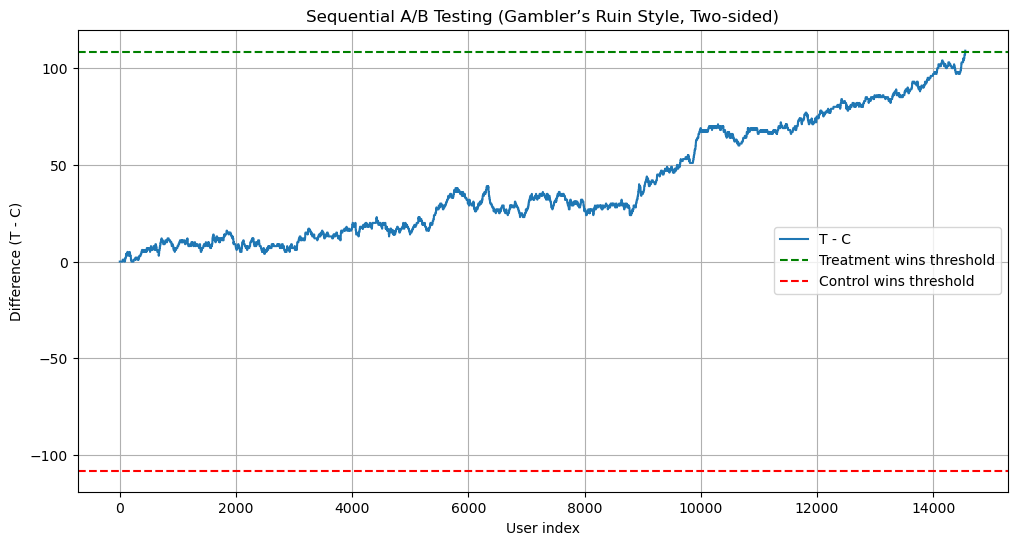

In [58]:
import matplotlib.pyplot as plt
# Параметры (запускаете калькулятор и вперед)
p_control = 0.10
p_treatment = 0.11
N = int(2922/(p_control))  # общее количество пользователей
threshold = 2 * np.sqrt(2922)
# 2.25
# Генерация данных
np.random.seed(42)
assignments = np.random.choice(["control", "treatment"], size=N)
outcomes = np.zeros(N)

# Назначаем конверсии
for i in range(N):
    if assignments[i] == "control":
        outcomes[i] = np.random.binomial(1, p_control)
    else:
        outcomes[i] = np.random.binomial(1, p_treatment)

# Последовательный подсчет
T = 0  # успехи treatment
C = 0  # успехи control
history = []

for i in range(N):
    group = assignments[i]
    outcome = outcomes[i]

    if group == "treatment":
        T += outcome
    else:
        C += outcome

    history.append(T - C)

    diff = T - C
    if diff >= threshold:
        print(f"[{i+1}] Treatment wins: T - C = {diff:.2f} ≥ {threshold:.2f}")
        break
    elif -diff >= threshold:
        print(f"[{i+1}] Control wins: C - T = {-diff:.2f} ≥ {threshold:.2f}")
        break

else:
    print(f"[{N}] No winner after {N} users. Final T={T}, C={C}, T-C={T-C}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(history, label="T - C")
plt.axhline(threshold, color="green", linestyle="--", label="Treatment wins threshold")
plt.axhline(-threshold, color="red", linestyle="--", label="Control wins threshold")
plt.xlabel("User index")
plt.ylabel("Difference (T - C)")
plt.title("Sequential A/B Testing (Gambler’s Ruin Style, Two-sided)")
plt.legend()
plt.grid(True)
plt.show()

# SPRT (Sequential Probability Ratio Test)


## Что такое SPRT?

**SPRT (Sequential Probability Ratio Test)** — метод последовательного тестирования гипотез, предложенный А. Вальдом (Wald, 1947), в котором:

* Проверка гипотез проводится **пошагово** (после каждого наблюдения или блока),
* На каждом шаге сравнивается **[отношение правдоподобий](https://en.wikipedia.org/wiki/Likelihood_function#Likelihood_ratio)** двух гипотез:

  * $H_0$: нулевой эффект,
  * $H_1$: заданный альтернативный эффект.


## Применение в A/B тестах

Мы хотим сравнить две гипотезы:

* $H_0: \delta = 0$ — нет эффекта (разности сред),
* $H_1: \delta = \delta_1 \neq 0$ — эффект есть, двухсторонняя альтернатива.


## Классический SPRT (односторонний)

Для случая с нормальными данными и известной дисперсией работает так:

Получаем  кусок данных, считаем по нему отношение правдоподобий.

$$
\Lambda_n = \log \left( \frac{L(\text{данные} \mid H_1)}{L(\text{данные} \mid H_0)} \right)
$$

Далее сравниваем с границами, если граница не пробита, добавляем еще данных (ждем дальше).

Тест продолжается до тех пор, пока $\Lambda_n$ не выходит за границы:

$$
\Lambda_n \ge \log\left(\frac{1 - \beta}{\alpha}\right) \Rightarrow \text{принять } H_1 \\
\Lambda_n \le \log\left(\frac{\beta}{1 - \alpha}\right) \Rightarrow \text{принять } H_0 \\
\text{иначе: продолжаем сбор данных}
$$

где $\alpha$ — ошибка I рода, $\beta$ — ошибка II рода.

Тут есть пара проблем:

  * Что делать , если тест двусторонний?,
  * Что делать, если $\delta$ не задана?



## 📘 Двусторонний SPRT для среднего (по [Schnuerch & Erdfelder, 2020](https://martinschnuerch.com/wp-content/uploads/2020/08/Schnuerch_Erdfelder_2020.pdf))


Пусть $X_i \sim \mathcal{N}(\mu, \sigma^2)$ — независимые наблюдения с известной дисперсией.

Гипотезы:

* $H_0: \mu = \mu_0$
* $H_1: \mu = \mu_0 \pm \delta$, то есть $\mu = \mu_0 + \delta$ или $\mu = \mu_0 - \delta$

Как видно, мы симметризовали задачку в обе стороны :)

## Что теперь делать?

Предположим, что у нас $n$ наблюдений, и их среднее:

$$
\bar{X}_n = \frac{1}{n} \sum_{i=1}^n X_i
$$

<!-- Тогда классическое отношение правдоподобий выглядит так:

$$
\Lambda_n^{(+)} = \log \left( \frac{f(\bar{X}_n \mid \mu = \mu_0 + \delta)}{f(\bar{X}_n \mid \mu = \mu_0)} \right)
$$

$$
\Lambda_n^{(-)} = \log \left( \frac{f(\bar{X}_n \mid \mu = \mu_0 - \delta)}{f(\bar{X}_n \mid \mu = \mu_0)} \right)
$$

А для двустороннего SPRT используется:

$$
\Lambda_n = \log \left( \frac{1}{2} \left[ \exp(\Lambda_n^{(+)}) + \exp(\Lambda_n^{(-)}) \right] \right)
$$

Или проще (по формуле из статьи):

$$
\Lambda_n = \log \left( \frac{1}{2} \left[ \exp\left(\frac{n \delta}{\sigma^2}(\bar{X}_n - \mu_0) - \frac{n \delta^2}{2\sigma^2} \right) + \exp\left(-\frac{n \delta}{\sigma^2}(\bar{X}_n - \mu_0) - \frac{n \delta^2}{2\sigma^2} \right) \right] \right)
$$
 -->
В статье Шнюрха и Эрдфельдера (Schnuerch & Erdfelder, 2020) описан двусторонний SPRT, основанный на t-статистике, предложенный Хайналом (Hajnal, 1961). Основная идея — использование отношения правдоподобия (likelihood ratio, LR), выраженного через плотности распределений квадрата t-статистики при различных гипотезах.

---

### 📌 Основные обозначения:

* $t_m$: t-статистика на шаге $m$
 
* $F_m = t_m^2$: квадрат t-статистики, имеет распределение F(1, df)

* $df_m = n_1 + n_2 - 2$: степени свободы

* $\delta$: стандартный эффект (например, Cohen’s d)

* $\lambda = \delta \cdot \sqrt{ \frac{n_1 n_2}{n_1 + n_2} }$: нецентральный параметр

* $\alpha, \beta$: ошибки первого и второго рода

* $A = \frac{1 - \beta}{\alpha}, \quad B = \frac{\beta}{1 - \alpha}$: границы SPRT

Напоминалка про Cohen's d:

<img src = "https://github.com/pileyan/pictures/blob/master/cohens_d.jpeg?raw=true" width=800>

### 🔹 Формула отношения правдоподобия (двусторонний SPRT):

$$
\text{LR}_m = \frac{f(F_m \mid d_1 = 1, d_2 = df_m, \text{nc} = \lambda^2)}{f(F_m \mid d_1 = 1, d_2 = df_m)}
$$

где:

* $f(\cdot)$: плотность распределения F
* Числитель — плотность нецентрального F-распределения
* Знаменатель — плотность центрального F-распределения

---

### 🔹 Решающее правило:

На каждом шаге $m$, после очередной выборки:

* Если $\text{LR}_m \ge A$, принять $H_1$
* Если $\text{LR}_m \le B$, принять $H_0$
* Иначе — продолжить выборку

---

### 🔹 Вспомогательные формулы:

* t-статистика (две независимые выборки):

$$
t_m = \frac{\bar{X}_1 - \bar{X}_2}{S_p \cdot \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}
$$

где $S_p$ — объединённая стандартная ошибка (pooled SD):

$$
S_p^2 = \frac{(n_1 - 1) s_1^2 + (n_2 - 1) s_2^2}{n_1 + n_2 - 2}
$$


Так, первую проблему решили. двусторонняя гипотеза есть. Теперь надо разобраться с $\delta$.


### Почему нельзя просто оставить $\delta$ неопределённой?

Sequential tests (в том числе SPRT, group sequential и т.д.) требуют **явного указания альтернативной гипотезы**, чтобы построить отношение правдоподобий. Это не тот случай, где можно протестировать любую разницу. Нужно знать, **против чего мы тестируем**:

$$
H_1: \mu = \mu_0 \pm \delta
$$

Без $\delta$ невозможно:

* Посчитать логарифм отношения правдоподобий
* Построить границы остановки
* Гарантировать заданный уровень ошибок I и II рода


### Как выбрать $\delta$ на практике?

1. **Бизнес-значимость**:
   Например, если в A/B тесте даже +0.2% конверсии не влияет на прибыль — тестировать такую разницу бессмысленно. Тогда можно взять $\delta = 0.005$ (0.5%) как минимально интересную разницу.

2. **Исторические данные**:
   Если известно, что типичные изменения фичи дают эффект \~1%, можно выбрать $\delta$ на основе исторических данных.

3. **Сравнение с дисперсией**:
   Если известна стандартная ошибка $\sigma$, то можно задать $\delta = c \cdot \sigma$, где $c$ — константа (например, 0.3 или 0.5).

К сожалению, мою реализацию с прямым вычилением F-распределения все время вышибает по численной стабильности и я устал ее править - может быть, найдется смельчак и перепишет это. Я наковырял "детский пример" накодил его.

In [422]:
from scipy.stats import f, ncf


def get_sprt_bounds(alpha=0.05, beta=0.2):
    A = (1 - beta) / alpha
    B = beta / (1 - alpha)
    return B, A

def compute_lr_t2(t_stat, df, ncp):
    f_val = t_stat**2
    with np.errstate(all='ignore'):  # Suppress warnings temporarily
        numerator = ncf.pdf(f_val, dfn=1, dfd=df, nc=ncp**2)
        denominator = f.pdf(f_val, dfn=1, dfd=df)
    if denominator < 1e-300:
        return np.inf if numerator > 0 else 0
    
    ratio = numerator / denominator
    return np.clip(ratio, 1e-300, 1e300)  # Prevent actual infinity

def run_hajnal_sprt_step(x1_stream, x2_stream, d_alt=0.1, 
                        alpha=0.05, beta=0.2, max_n=10**5, step=10): 
    B, A = get_sprt_bounds(alpha, beta)
    x1, x2 = x1_stream, x2_stream
    n1, n2 = len(x1), len(x2)
    df = n1 + n2 - 2
    t_stat, _ = ttest_ind(x1, x2, equal_var=True)
    ncp = d_alt * np.sqrt(n1 * n2 / (n1 + n2))
    lr = compute_lr_t2(t_stat, df, ncp)

    if lr >= A or lr > 1e100:
        return 1, lr
    elif lr <= B or lr < 1e-100:
        return 0, lr
    return -1, lr

In [448]:
mu1, mu2 = 0, 0.1  # Средние в двух распределениях
sigma = 1
d_alt = (mu2 - mu1)/sigma  # Предполагаемая дельта - тут можно поиграть)))
max_n = 1000
step_size = 10

# Датасет
x1_full = np.random.normal(mu1, sigma, max_n)
x2_full = np.random.normal(mu2, sigma, max_n)

# Последовательное
x1, x2 = np.array([]), np.array([])
samples_taken = 0
decision = -1

print("Запускаем последовательный счет:")
for i in range(0, max_n, step_size):
    x1 = np.concatenate([x1, x1_full[i:i+step_size]])
    x2 = np.concatenate([x2, x2_full[i:i+step_size]])
    samples_taken += step_size
    
    #  Hajnal SPRT
    result, lr = run_hajnal_sprt_step(x1, x2, d_alt=d_alt)
    
    # Результат
    if result != -1:
        decision = result
        print(f"\nHajnal SPRT остановлен на {samples_taken} примерах")
        print(f"Ответ: {'Reject H0' if result == 1 else 'Accept H0'}")
        print(f"Likelihood Ratio: {lr:.4f}")
        break

# Сравнения
if decision == -1:
    print("\nHajnal SPRT дошел до max_n, решения не принято")
    samples_taken = max_n

# Прогоним t-тест на моменте остановки Hajnal SPRT
t_stat, p_value = ttest_ind(x1, x2, equal_var=True)
print(f"\nt-test на {samples_taken} объектов:")
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
print(f"Traditional conclusion: {'Reject H0' if p_value < 0.05 else 'Fail to reject H0'}")

# Прогон t-теста на полном датасете
full_t_stat, full_p_value = ttest_ind(x1_full, x2_full, equal_var=True)
print(f"\nt-test на всем датасете ({max_n} объектов):")
print(f"Ответ: {full_t_stat:.4f}, p-value: {full_p_value:.4f}")
print(f"Ответ: {'Reject H0' if full_p_value < 0.05 else 'Fail to reject H0'}")

Запускаем последовательный счет:

Hajnal SPRT остановлен на 790 примерах
Ответ: Accept H0
Likelihood Ratio: 0.1947

t-test на 790 объектов:
t-statistic: 0.4376, p-value: 0.6617
Traditional conclusion: Fail to reject H0

t-test на всем датасете (1000 объектов):
Ответ: 0.0153, p-value: 0.9878
Ответ: Fail to reject H0


# GST (Group Sequential testing)

Если что, про метод уже писал [ТБанк](https://habr.com/ru/companies/tbank/articles/876984/), а еще почитать можно в материалах: [раз](https://keaven.github.io/gsd-tech-manual/), [два](https://online.stat.psu.edu/stat509/lesson/9/9.5).
До сих пор мы, на самом деле, могли подглядывать сколько угодно раз, но для нас это +- бесполезное занятие, поскольку данные в корпоративное хранилище данных приезжают дискретно, например у нас – подневно. Поэтому "подглядеть" в эксперимент, длящийся 2 недели, мы **физически не сможем больше 14 раз**. Предлагается "распределить" $\alpha$ по этим "подглядываниям" таким образом, чтобы в целом $\alpha$ сохранилось (немного напоминает поправку Бонферрони в множественном тестировании).

Теперь разберемся, как работает метод **GST** (Group Sequential testing) (грубо говоря, как "тратить" уровень значимости $\alpha$ в ходе исследования на каждое "подглядывание", не нарушая общее $\alpha$). В блоке про **SPRT** на промежуточных подглядываниях мы просто сравнивали некоторую статистику (отношение правдоподобия) с какими-то хитрыми границами. Тут мы вообще можем взять $t$-статистику и подобрать границы для нее (ну или сравнивать *pvalue* на каждом шаге со своим $\alpha$, что то же самое.  Возьмем односторонний тест (для двустороннего просто поделим $\alpha$ на 2 и зеркально отразим границы относительно нуля (симметрия).

Представьте броуновское движение $W(t)$ (случайное блуждание во времени от 0 до 1, да, прямо как в **блоке про разорение игрока**). Наша задача — поймать момент $\tau$, когда оно **впервые** пересечет границу $b(t) = z_{\alpha/2}$. Если обозначить $\alpha^*(t)$ как вероятность, что это случится до момента $t$, то формула будет такой:

$$
\alpha^*(t) = 
\begin{cases} 
0, & t = 0, \\ 
2 - 2 \cdot \Phi\left(\frac{z_{\alpha/2}}{\sqrt{t}}\right), & t > 0,
\end{cases}
$$

где $\Phi$ — функция стандартного нормального распределения (та самая, которая в таблицах). Заметьте: $\alpha^*(t)$ растет со временем и к $t=1$ достигает $\alpha$. Это и есть наша **alpha-spending функция** — она "тратит" $\alpha$ по мере продвижения анализа.

Теперь допустим, что мы заглядываем в данные только в моменты $t_1, t_2, \dots, t_K = 1$. Нам нужно подобрать границы $b_1, b_2, \dots, b_K$ так, чтобы:

1. На первом этапе $t_1$:  
   $$\mathbb{P}(B(t_1) > b_1) = \alpha^*(t_1)$$  
   (тут всё просто — $b_1$ считаем аналитически).

2. На последующих этапах $t_i$:  
   $$\mathbb{P}(\text{не пересекли до } t_{i-1}, \text{ но пересекли на } t_i) = \alpha^*(t_i) - \alpha^*(t_{i-1})$$.  

Но вот загвоздка: для $b_2, b_3, \dots$ уже нужны численные методы (типа интегралов по траекториям броуновского движения). Каждая следующая граница $b_i$ зависит от предыдущих $b_j$ — как цепочка условий.

---
## Суть GST

можно брать **любую** alpha-spending функцию, которая:  
- строго растет с $t$,  
- в конце дает $\alpha^*(1) = \alpha$.  

Например, как "тратить" $\alpha$ равномерно, или вперед/назад — выбор за нами. Главное, чтобы общая вероятность ложного вывода $\alpha$ не превышала заданного уровня. Всё это нужно, чтобы не накрутить false positive при множественных проверках. Как по мне, довольно круто :)

Еще раз:

**Alpha-spending function** $\alpha(t)$ — это функция, определяющая, **сколько из общего уровня значимости $\alpha$** допустимо «потратить» на каждом временном шаге $t \in [0, 1]$, где:

* $t$ — кумулятивная доля информации (например, 0.25 означает, что 25% данных собрано),
* $\alpha(t)$ — суммарный уровень значимости, разрешённый до момента $t$.

Граница остановки на шаге $t_k$ рассчитывается так, чтобы обеспечивать, что **суммарная вероятность ложноположительного решения до этого момента не превышает** $\alpha(t_k)$.

---

## Формулы для Alpha-Spending функций

### 📌 O’Brien-Fleming:

$$
\alpha(t) = 2 \left(1 - \Phi\left( \frac{z_{\alpha}}{\sqrt{t}} \right) \right)
$$

* Расходует очень мало альфы в начале, почти всё — в конце.
* Соответствует строгим границам на ранних этапах.

---

### 📌 Pocock:

$$
\alpha(t) = \alpha \cdot \log(1 + (e - 1) \cdot t)
$$

* $\pm$ Равномерная альфа-расходующая функция.
* Ранние и поздние границы +- одинаково «мягкие».

---

Другие варианты функций можно посмотреть [здесь](https://online.stat.psu.edu/stat509/lesson/9/9.5)

## 📌 Связь с границами остановки

После нахождения $\alpha(t_k)$, граница остановки на этапе $t_k$ будет:

$$
b_k = \Phi^{-1}(1 - \alpha(t_k) / 2)
$$

* Для OBF граница сначала **высокая**, потом снижается.
* Для Pocock граница **практически постоянна** на всех этапах.


## 📈 Что показывает график:

* Красные границы — **Pocock** (постоянные или почти постоянные),
* Синие границы — **O'Brien-Fleming** (строгие в начале, мягче в конце),
* Красная/синяя точка — где тест был **остановлен досрочно**.

---

## 📌 Выводы:

| Граница             | Поведение                                         |
| ------------------- | ------------------------------------------------- |
| **Pocock**          | Равномерные границы → легче остановка рано        |
| **O'Brien-Fleming** | Консервативно на ранних этапах, мощнее в финале |

Рассмотрим Пример:

Пусть мы принимаемся на $\alpha = 0.05$ и сравниваем конверсии в двух группах. Считаем, что в каждой группе по 20000 пользователей, базовый уровень конверсии в контроле $10%$, а в тестовой группе - $11%$. Подглядывать в данные мы будем 4 раза через равные интервалы. 

Далее просто нарисуем на графике границы, которые получаются из методов Покока и О'Брайена-Флеминга и посмотрим, когда $z$-статистика эти границы пересечет.

P.S. Эти рисуночки исключительно для наглядности :)


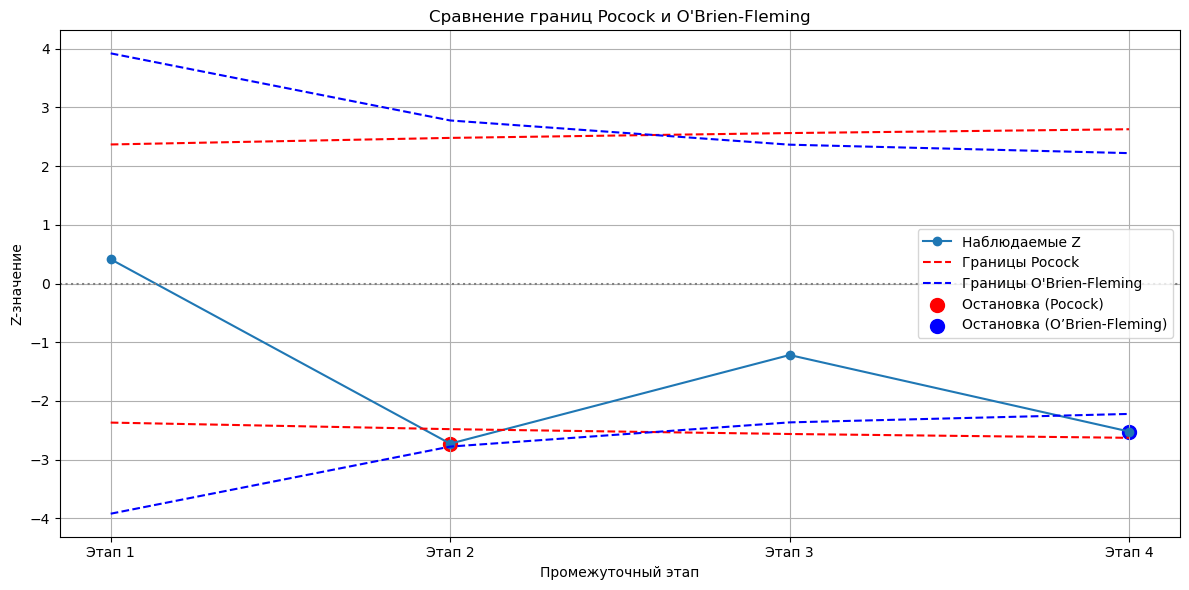

In [245]:
# Параметры
alpha = 0.05
n_looks = 4
total_users = 20000
look_fractions = np.linspace(0.25, 1.0, n_looks)
conv_a = 0.10
conv_b = 0.11  # попробуй 0.10 для A/A

# Альфа-функции
def pocock_spending(t, alpha=0.05):
    return alpha * np.log(1 + (np.e - 1) * t)

def obrien_fleming_spending(t, alpha=0.05):
    z_alpha = norm.ppf(1 - alpha / 2)
    return 2 * (1 - norm.cdf(z_alpha / np.sqrt(t)))
#----------------------------------------------------



# Z-тест пропорций
def z_test(group_a, group_b):
    n1 = len(group_a)
    n2 = len(group_b)
    p1 = np.mean(group_a)
    p2 = np.mean(group_b)
    p_pool = (np.sum(group_a) + np.sum(group_b)) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    z = (p1 - p2) / se
    return z

# Генерация кумулятивных границ для Pocock и O'Brien-Fleming
def get_cumulative_bounds(look_fractions, alpha, spending_func):
    cumulative_alpha = np.array([spending_func(t, alpha) for t in look_fractions])
    # вычисление разницы между кумулятивными уровнями значимости для каждого шага
    delta_alpha = np.diff(np.insert(cumulative_alpha, 0, 0))
    bounds = norm.ppf(1 - delta_alpha / 2)  # для двустороннего теста делим на 2
    return bounds

# Симуляция
z_scores = []
pocock_bounds = []
of_bounds = []
stop_pocock = stop_of = None

# Генерация кумулятивных границ для Pocock и O'Brien-Fleming
pocock_bounds = get_cumulative_bounds(look_fractions, alpha, pocock_spending)
of_bounds = get_cumulative_bounds(look_fractions, alpha, obrien_fleming_spending)

# Симуляции на каждом шаге
for i, frac in enumerate(look_fractions):
    n = int(total_users * frac)
    
    group_a = np.random.binomial(1, conv_a, size=n)
    group_b = np.random.binomial(1, conv_b, size=n)
    
    z = z_test(group_a, group_b)
    z_scores.append(z)
    
    # фиксируем остановку
    if stop_pocock is None and abs(z) > pocock_bounds[i]:
        stop_pocock = i
    if stop_of is None and abs(z) > of_bounds[i]:
        stop_of = i

# График сравнения
x = np.arange(1, n_looks + 1)
plt.figure(figsize=(12, 6))
plt.plot(x, z_scores, label="Наблюдаемые Z", marker='o')
plt.plot(x, pocock_bounds, '--r', label="Границы Pocock")
plt.plot(x, [-b for b in pocock_bounds], '--r')
plt.plot(x, of_bounds, '--b', label="Границы O'Brien-Fleming")
plt.plot(x, [-b for b in of_bounds], '--b')

# отметки остановки
if stop_pocock is not None:
    plt.scatter(x[stop_pocock], z_scores[stop_pocock], color='red', s=100, label='Остановка (Pocock)')
if stop_of is not None:
    plt.scatter(x[stop_of], z_scores[stop_of], color='blue', s=100, label='Остановка (O’Brien-Fleming)')

plt.axhline(0, color='gray', linestyle=':')
plt.xticks(x, [f"Этап {i}" for i in x])
plt.xlabel("Промежуточный этап")
plt.ylabel("Z-значение")
plt.title("Сравнение границ Pocock и O'Brien-Fleming")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


| Метод              | Ошибка I рода (α)  | Ошибка II рода (β)                         |
| ------------------ | ------------------ | ------------------------------------------ |
| ✅ Обычный t-тест   | фиксированная α    | зависит от мощности                        |
| 🧪 Pocock          | равномерное α      | может иметь меньшую мощность               |
| 🧪 O'Brien-Fleming | строгая α в начале | высокая мощность, но требует больше данных |

---

Следующей итерацией нам нужно проверить другую постановку задачи, более близкую к нашей реальности - выборки в группах А и Б нормальные c равными дисперсиями. 

## Условия симуляции:

* 1000 повторений ,
* Контрольная конверсия: 10%,
* Эффект в A/A: `0` (для оценки ошибок I рода),
* Эффект в A/B: `+3%.` (1 → 1.03), для оценки ошибок II рода (мощности),
* 10 промежуточных замеров на равных интервалах,
* Используется t-тест для среднего,
* Сравниваем: обычный тест, Pocock, O'Brien-Fleming.

## За чем следим:

* Доля ложноположительного на АА
* Мощность (Доля "сработавших" тестов на АБ)
* На какой доле увиденных данных тест сработал, если он сработал (будет гистограмма)



In [207]:
from tqdm import tqdm

# Параметры
alpha = 0.05
n_total = 20000  # Общий размер выборки
n_looks = 10  # Количество промежуточных анализов
look_fractions = np.linspace(1/10, 1.0, n_looks)  # Доли данных для анализа
n_simulations = 1000  # Количество симуляций

mean_A = 1.0
effect = 0.03  # Размер эффекта (3%)
mean_B = mean_A * (1 + effect)


# Предварительный расчёт границ
bounds_of = compute_bounds(obrien_fleming_spending, n_looks, alpha)
bounds_pocock = compute_bounds(pocock_spending, n_looks, alpha)
bound_classic = norm.ppf(1 - alpha/2)

def run_simulation(mean_A, mean_B, strategy):
    rejections = 0
    lookups = []
    for _ in tqdm(range(n_simulations)):
        # Генерируем ВСЕ данные заранее (кумулятивно)
        a_full = np.random.normal(mean_A, 1, n_total)
        b_full = np.random.normal(mean_B, 1, n_total)
        
        stopped = False
        for i, frac in enumerate(look_fractions):
            # Берём кумулятивные данные
            n = int(n_total * frac)
            a = a_full[:n]
            b = b_full[:n]
            
            # Считаем z-статистику вручную (для согласованности с границами)
            mean_diff = np.mean(b) - np.mean(a)
            std_err = np.sqrt(np.var(a)/n + np.var(b)/n)
            z = mean_diff / std_err
            
            # Выбираем границу в зависимости от стратегии
            if strategy == 'classic':
                if frac < 1.0:  # Только финальный анализ
                    continue
                bound = bound_classic
            elif strategy == 'obrien-fleming':
                bound = bounds_of[i]
            elif strategy == 'pocock':
                bound = bounds_pocock[i]
            
            if abs(z) > bound:
                rejections += 1
                lookups.append(frac)
                stopped = True
                break
                
        # Учёт случаев, когда ни разу не пересекли границу
        if not stopped and strategy == 'classic':
            n = n_total
            a = a_full[:n]
            b = b_full[:n]
            mean_diff = np.mean(b) - np.mean(a)
            std_err = np.sqrt(np.var(a)/n + np.var(b)/n)
            z = mean_diff / std_err
            if abs(z) > bound_classic:
                rejections += 1
    return rejections / n_simulations, lookups


# Запуск симуляции АА
print("=== Мощность (A/А тест) ===")
alpha_cl, _ = run_simulation(mean_A, mean_A, 'classic')
alpha_po, _ = run_simulation(mean_A, mean_A, 'pocock')
alpha_of, _ = run_simulation(mean_A, mean_A, 'obrien-fleming')

print(f"Классический t-тест: {alpha_cl:.3f}")
print(f"Pocock:             {alpha_po:.3f}")
print(f"O'Brien-Fleming:    {alpha_of:.3f}")


# Запуск симуляции АБ
print("=== Мощность (A/B тест) ===")
power_cl, _ = run_simulation(mean_A, mean_B, 'classic')
power_po, lookups_po = run_simulation(mean_A, mean_B, 'pocock')
power_of, lookups_of = run_simulation(mean_A, mean_B, 'obrien-fleming')

print(f"Классический t-тест: {power_classic:.3f}")
print(f"Pocock:             {power_pocock:.3f}")
print(f"O'Brien-Fleming:    {power_of:.3f}")

=== Мощность (A/А тест) ===


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1059.86it/s]


Классический t-тест: 0.053
Pocock:             0.028
O'Brien-Fleming:    0.021
=== Мощность (A/B тест) ===


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1216.57it/s]

Классический t-тест: 0.859
Pocock:             0.705
O'Brien-Fleming:    0.719


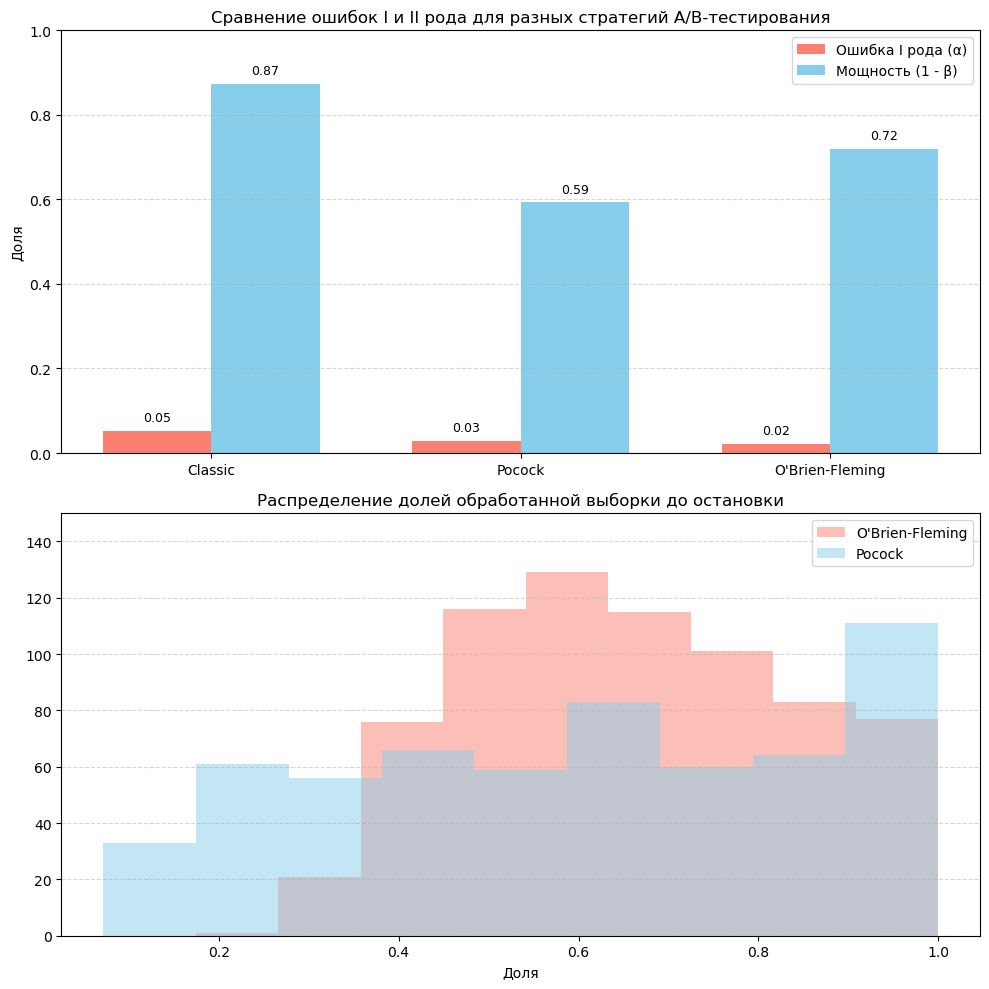

In [237]:
# Осталось порисовать :)
alpha_values = {
    'Classic': alpha_cl,
    'Pocock': alpha_po,
    "O'Brien-Fleming": alpha_of
}

power_values = {
    'Classic': power_cl,
    'Pocock': power_po,
    "O'Brien-Fleming": power_of
}

methods = list(alpha_values.keys())

# Строим графики
x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(2,1, figsize=(10, 10))

bar1 = ax[0].bar(x - width/2, [alpha_values[m] for m in methods], width, label='Ошибка I рода (α)', color='salmon')
bar2 = ax[0].bar(x + width/2, [power_values[m] for m in methods], width, label='Мощность (1 - β)', color='skyblue')

# Подписи и формат раз
ax[0].set_ylabel('Доля')
ax[0].set_title('Сравнение ошибок I и II рода для разных стратегий A/B-тестирования')
ax[0].set_xticks(x)
ax[0].set_xticklabels(methods)
ax[0].set_ylim(0, 1)
ax[0].legend()
ax[0].grid(True, axis='y', linestyle='--', alpha=0.5)

# Подписи на столбцах
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax[0].annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(bar1)
autolabel(bar2)

# Подписи и формат два
h1 = ax[1].hist(lookups_of, bins = 9, label = 'O\'Brien-Fleming', alpha=0.5, color='salmon')
h2 = ax[1].hist(lookups_po, bins = 9, label = 'Pocock', alpha=0.5, color='skyblue')
ax[1].set_xlabel('Доля')
ax[1].set_title('Распределение долей обработанной выборки до остановки')
ax[1].set_ylim(0, 150)
ax[1].legend()
ax[1].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Тут видно, что контроль за ложноположительным у обоих методов есть, но мощность у О'Брайена-Флеминга выше, кроме того, тест не срабатывает в самом начале, что (на мой взгляд) является предпочтительным поведением. 


# CUSUM


**CUSUM (CUmulative SUM)** — метод, разработанный для обнаружения изменений в параметрах распределения временного ряда. Основная идея заключается в **кумулятивном суммировании отклонений** наблюдаемых значений от ожидаемых (измеряется в терминах правдоподобия). Метод  эффективен для обнаружения **малых и постепенных изменений**.

### Алгоритм работы:
1. **Определение целевого параметра**: Например, среднее $\mu$ или интенсивность $\lambda$ для распределения Пуассона.
2. **Расчет отклонений**: Для каждого наблюдения вычисляется разница между наблюдаемым значением и ожидаемым (до изменения) в терминах правдоподобия.
3. **Накопление суммы**: Отклонения накапливаются с учетом знака. Если сумма превышает заданный порог, фиксируется изменение распределения.


## CUSUM для распределения Пуассона

Пусть временной ряд $X_t$ следует распределению Пуассона с параметром $\lambda$:
$$
X_t \sim \text{Poisson}(\lambda).
$$
Предположим, что в некоторой точке $\tau$ (change point) параметр $\lambda$ уменьшается до $\lambda_1 < \lambda_0$. В задаче, которая рассматривается у нас в задаче поиска остановки продаж крайний случай: $\lambda_1 = 0$, и все наблюдения после $\tau$ равны 0. В правдоподобие мы, конечно, 0 не ставим - ставим просто маленькую чиселку.

### Формализация гипотез:
- $ H_0 :  \lambda = \lambda_0 $ (изменения нет).
- $H_1: \lambda = \lambda_1 $ (изменение произошло в точке $\tau $.

---

## Построение статистики CUSUM

Для распределения Пуассона **логарифм отношения правдоподобия** (Log-Likelihood Ratio, LLR) для наблюдения $X_t$:
$$
\text{LLR}_t = X_t \ln\left(\frac{\lambda_1}{\lambda_0}\right) - (\lambda_1 - \lambda_0).
$$

### Особый случай \( X_t = 0 \):
Если $\lambda_1 = 0$, то:
$$
\text{LLR}_t = 0 \cdot \ln\left(\frac{0}{\lambda_0}\right) - (0 - \lambda_0) = \lambda_0.
$$
Каждое наблюдение $X_t = 0$ добавляет $\lambda_0$ к кумулятивной сумме.

На практике мы пользуемся общей формулой, где $\lambda_1 = 0.001$

---

## Алгоритм обнаружения изменений

1. **Инициализация**: $S_0 = 0$.
2. **Рекуррентное обновление**:
$$
S_t = \max\left(0, S_{t-1} + \text{LLR}_t\right).
$$
3. **Правило остановки**: Если $S_t > h$, где $h$ — порог, фиксируется изменение.

### Выбор порога $h$:
Порог зависит от желаемого уровня ложных срабатываний. Для распределения Пуассона с $\lambda_0$, можно использовать аппроксимацию:
$$
h \approx \lambda_0 \cdot \ln\left(\frac{1}{\alpha}\right),
$$
где $\alpha$ — уровень значимости.

Но вообще - лучше бы его напрямую оценивать по данным с помощью Монте-Карло.


### Пример:

Рассмотрим временной ряд, где первые $N = 50$ наблюдений имеют $\lambda_0 = 3$, а последние $M = 10$ наблюдений — $\lambda_1 = 0$.





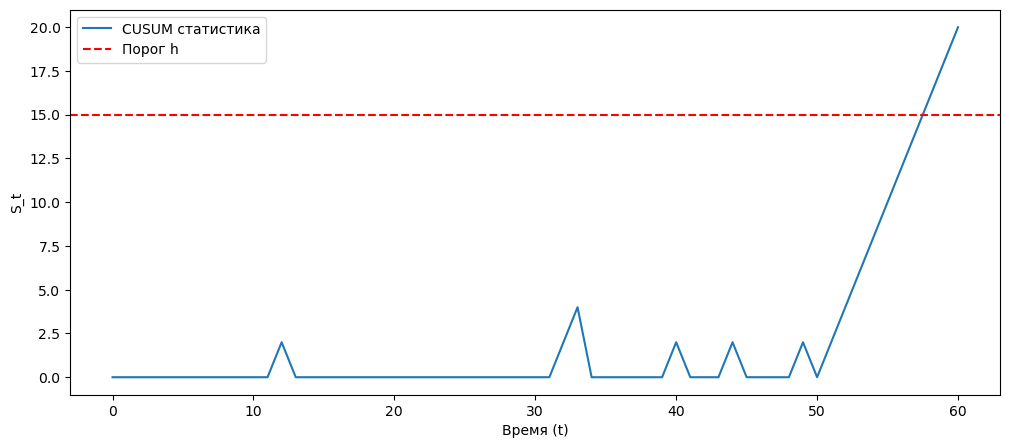

In [391]:
# Генерация данных
np.random.seed(42)
lambda0 = 2
data_before = np.random.poisson(lambda0, 50)
data_after = np.zeros(10)
data = np.concatenate([data_before, data_after])

# Параметры CUSUM
h = 15  # Порог
S = [0]  # Инициализация статистики

for t in range(len(data)):
    X_t = data[t]
    if X_t == 0:
        LLR = lambda0  # Поскольку lambda1 = 0
    else:
        LLR = X_t * np.log(0.001 / lambda0) - (0.001 - lambda0)  # lambda1 ~ 0
    
    S_new = max(0, S[-1] + LLR)
    S.append(S_new)

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(S, label='CUSUM статистика')
plt.axhline(h, color='r', linestyle='--', label='Порог h')
plt.xlabel('Время (t)')
plt.ylabel('S_t')
plt.legend()
plt.show()

Что получилось:

- Статистика $S_t$ начинает резко расти после 50-го наблюдения.
- Изменение фиксируется при пересечении порога $h$.

**To be done**:
- Калибровка порога $h$ через симуляции